# Fit the RLDDM on individual data

In [1]:
import rlssm
import pandas as pd
import os

## Import the data

In [2]:
par_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_path = os.path.join(par_path, 'data/data_experiment.csv')
data = pd.read_csv(data_path, index_col=0)

data = data[data.participant == 10].reset_index(drop=True) # Only select 1 participant

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,10,1,1,61,52,4,3,1,1.285418,0
1,10,1,2,54,37,4,2,1,1.577622,0
2,10,1,3,51,51,4,3,2,1.564731,0
3,10,1,4,50,35,3,1,2,1.217245,1
4,10,1,5,59,50,4,2,3,1.929781,0


## Initialize the model

In [3]:
# you can "turn on and off" different mechanisms:
model = rlssm.RLDDModel(hierarchical_levels=1,
                        separate_learning_rates=False,
                        threshold_modulation=False,
                        nonlinear_mapping=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a593b308fdcbb0efb6cdf619dae38a68 NOW.


## Fit

In [4]:
# sampling parameters
n_iter = 5000
n_chains = 2
n_thin = 5

# learning parameters
K = 4 # n options in a learning block (participants see 2 at a time)
initial_value_learning = 27.5 # intitial learning value (Q0)

In [5]:
model_fit = model.fit(
    data,
    K,
    initial_value_learning,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
17.0 of 1000 iterations ended with a divergence (1.7%)
  Try running with larger adapt_delta to remove the divergences
0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


### get Rhat

In [6]:
model_fit.rhat

,rhat,variable
0,1.204576,alpha
1,1.119181,drift_scaling
2,1.483771,drift_asymptote
3,1.000392,threshold
4,1.001357,ndt


### get wAIC

In [7]:
model_fit.waic

{'lppd': -221.54879127493658,
 'p_waic': 4.857734295448456,
 'waic': 452.8130511407701,
 'waic_se': 28.66145801468709}

## Posteriors

In [8]:
model_fit.samples.describe()

,chain,draw,transf_alpha,transf_drift_scaling,transf_drift_asymptote,transf_threshold,transf_ndt
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.50000,249.500000,0.029272,2.321832,22.782600,1.876618,0.796882
std,0.50025,144.409501,0.031579,8.590708,26.804748,0.067807,0.011499
min,0.00000,0.000000,0.000029,0.003783,2.037821,1.685138,0.750370
25%,0.00000,124.750000,0.008579,0.021988,3.666663,1.830036,0.788948
50%,0.50000,249.500000,0.020835,0.133735,9.039661,1.874219,0.798728
75%,1.00000,374.250000,0.038196,0.566907,34.996012,1.915422,0.804943
max,1.00000,499.000000,0.325258,101.528271,148.882355,2.100433,0.826730


In [9]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

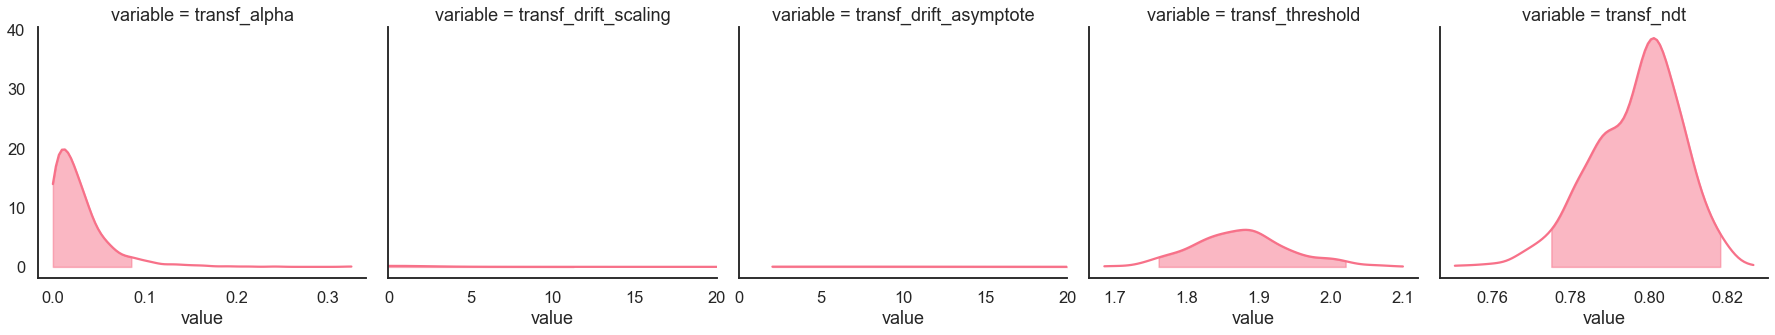

In [23]:
g = model_fit.plot_posteriors(height=5, show_intervals='HDI');

g.axes.flat[1].set_xlim(0, 20)
g.axes.flat[2].set_xlim(0, 20);

## Posterior predictives

### Ungrouped

In [24]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=100)
pp

variable        rt                                                    \
trial          1         2         3         4         5         6     
sample                                                                 
1         0.995739  1.189739  1.046739  1.322739  2.000739  1.023739   
2         1.035193  1.804193  1.201193  0.942193  0.941193  1.774193   
3         2.824901  1.096901  1.801901  1.064901  1.173901  2.129901   
4         0.903348  1.486348  1.996348  3.267348  1.120348  1.999348   
5         1.438481  1.019481  1.692481  2.379481  1.226481  1.892481   
...            ...       ...       ...       ...       ...       ...   
96        2.077033  2.461033  1.058033  1.399033  2.574033  1.250033   
97        1.583701  1.562701  1.278701  1.289701  0.925701  0.924701   
98        1.082223  2.052223  0.897223  1.370223  1.708223  1.614223   
99        2.879786  5.779786  1.053786  1.516786  1.432786  1.524786   
100       0.990727  1.745727  3.810727  1.346727  1.467727  2.050727   

variable                                          ... accuracy                 \
trial          7         8         9         10   ...      230  231  232  233   
sample                                            ...                           
1         1.630739  3.316739  0.977739  4.166739  ...      1.0  1.0  1.0  1.0   
2         3.124193  1.735193  1.665193  0.891193  ...      1.0  1.0  1.0  1.0   
3         1.324901  1.070901  1.111901  1.806901  ...      1.0  1.0  1.0  1.0   
4         2.272348  1.795348  1.170348  2.102348  ...      1.0  1.0  1.0  1.0   
5         1.140481  2.053481  1.470481  1.346481  ...      1.0  1.0  0.0  1.0   
...            ...       ...       ...       ...  ...      ...  ...  ...  ...   
96        1.166033  1.687033  1.197033  1.540033  ...      1.0  1.0  1.0  1.0   
97        1.243701  1.459701  1.006701  0.992701  ...      1.0  1.0  1.0  1.0   
98        0.969223  1.820223  1.600223  0.941223  ...      1.0  0.0  0.0  1.0   
99        4.250786  1.266786  1.700786  2.074786  ...      1.0  1.0  1.0  1.0   
100       1.184727  1.693727  1.522727  3.052727  ...      1.0  1.0  1.0  1.0   

variable                                
trial     234  235  236  237  238  239  
sample                                  
1         1.0  0.0  1.0  1.0  1.0  1.0  
2         1.0  1.0  0.0  1.0  1.0  1.0  
3         1.0  1.0  1.0  1.0  1.0  1.0  
4         1.0  1.0  1.0  0.0  1.0  1.0  
5         1.0  1.0  1.0  1.0  0.0  1.0  
...       ...  ...  ...  ...  ...  ...  
96        1.0  1.0  0.0  1.0  0.0  1.0  
97        1.0  1.0  1.0  1.0  1.0  0.0  
98        1.0  1.0  1.0  1.0  1.0  1.0  
99        1.0  0.0  1.0  1.0  0.0  0.0  
100       1.0  1.0  1.0  1.0  1.0  1.0  

[100 rows x 478 columns]

In [25]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=100)
pp_summary

,mean_accuracy,mean_rt,skewness,quant_10_rt_low,quant_30_rt_low,quant_50_rt_low,quant_70_rt_low,quant_90_rt_low,quant_10_rt_up,quant_30_rt_up,quant_50_rt_up,quant_70_rt_up,quant_90_rt_up
sample,,,,,,,,,,,,,
1,0.740586,1.555893,2.246113,1.078239,1.196539,1.404239,1.684139,2.252639,1.003939,1.167539,1.364739,1.655939,2.206139
2,0.811715,1.622947,1.570472,1.039393,1.214793,1.576193,2.121993,2.702793,1.020593,1.184693,1.415193,1.710493,2.469693
3,0.748954,1.544896,1.548014,1.073301,1.229401,1.483401,1.891001,2.622101,0.974901,1.198301,1.380901,1.613701,2.083101
4,0.719665,1.517704,1.886846,1.022948,1.173948,1.421348,1.819948,2.620348,1.002348,1.143448,1.290348,1.534148,2.057948
5,0.782427,1.648673,1.461054,0.974581,1.174581,1.337481,1.852081,2.284081,1.029881,1.252081,1.510481,1.826081,2.580881
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.828452,1.473046,2.056585,0.986033,1.107033,1.360033,1.697033,2.566033,1.021133,1.148533,1.303033,1.561533,1.992433
97,0.769874,1.645253,3.697219,1.033701,1.232901,1.549701,1.941701,2.682101,1.008001,1.152501,1.378201,1.721001,2.534401
98,0.799163,1.473194,2.413293,0.943723,1.146923,1.393723,1.781623,2.399623,0.987223,1.118223,1.288223,1.489223,2.011223


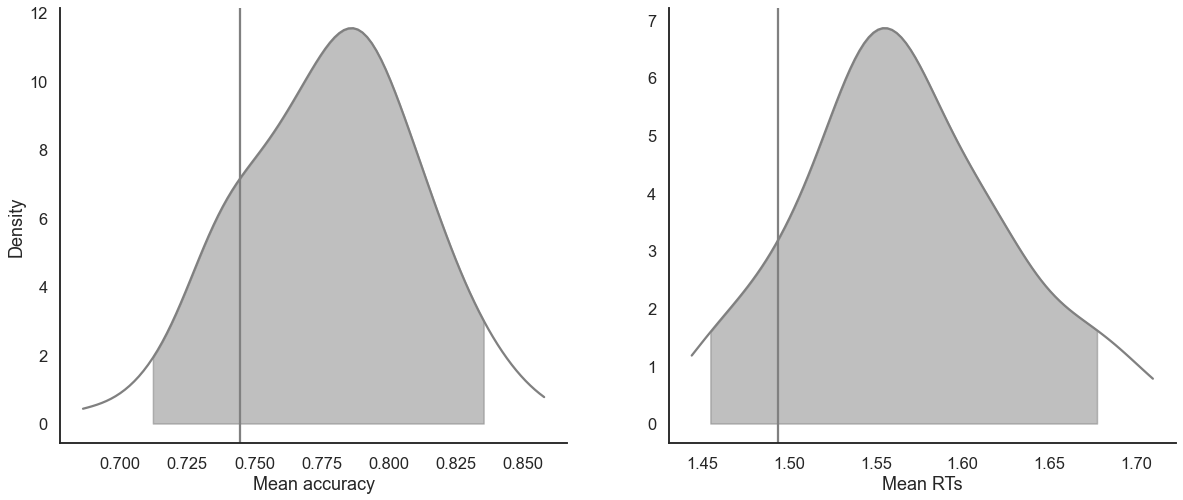

In [26]:
model_fit.plot_mean_posterior_predictives(n_posterior_predictives=100, figsize=(20,8), show_intervals='HDI');

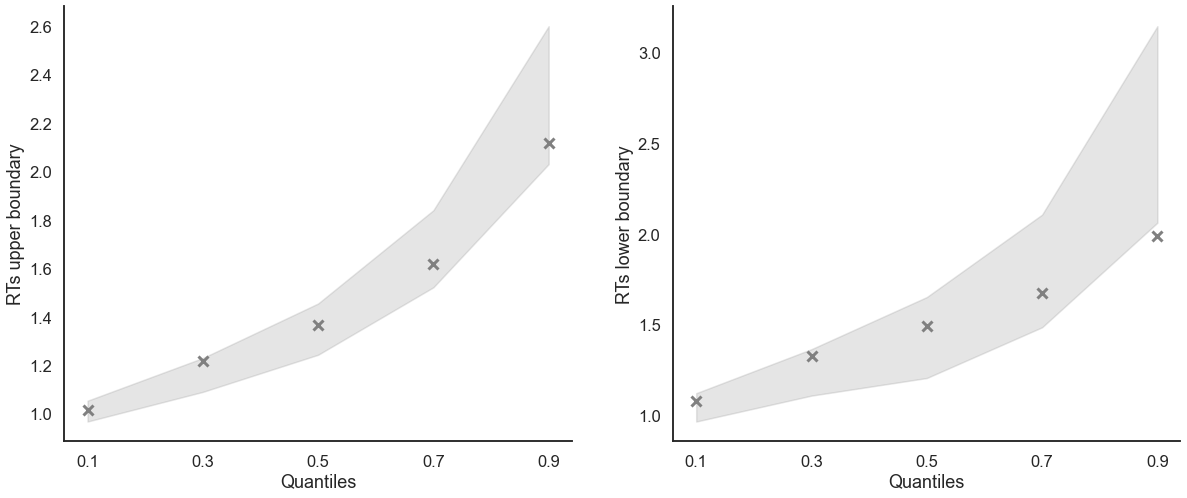

In [27]:
model_fit.plot_quantiles_posterior_predictives(n_posterior_predictives=100, kind='shades');

### Grouped

In [28]:
import numpy as np

In [29]:
# Define new grouping variables, in this case, for the different choice pairs, but any grouping var can do
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [30]:
model_fit.get_grouped_posterior_predictives_summary(
                grouping_vars=['block_label', 'choice_pair'],
                quantiles=[.3, .5, .7],
                n_posterior_predictives=100)

mean_accuracy   mean_rt  skewness  \
block_label choice_pair sample                                      
1           AB          1                0.55  1.741989  0.759599   
                        2                0.65  1.729893  2.274213   
                        3                0.75  1.556401  1.023839   
                        4                0.65  1.614948  2.341023   
                        5                0.70  1.571881  2.821500   
...                                       ...       ...       ...   
3           CD          96               0.65  1.529183  1.447944   
                        97               0.70  1.937301  1.873275   
                        98               0.70  1.471573  1.641041   
                        99               0.75  1.499436  1.539416   
                        100              0.60  1.675077  0.750515   

                                quant_30_rt_low  quant_30_rt_up  \
block_label choice_pair sample                                    
1           AB          1              1.230739        1.258739   
                        2              1.245793        1.059793   
                        3              1.735501        1.097501   
                        4              1.097948        1.256748   
                        5              1.098481        1.180981   
...                                         ...             ...   
3           CD          96             1.082433        1.195833   
                        97             1.395701        1.360101   
                        98             1.207223        1.114923   
                        99             1.192386        1.198786   
                        100            1.209027        1.243627   

                                quant_50_rt_low  quant_50_rt_up  \
block_label choice_pair sample                                    
1           AB          1              1.406739        1.522739   
                        2              1.466193        1.163193   
                        3              1.837901        1.254901   
                        4              1.117348        1.417348   
                        5              1.154981        1.345981   
...                                         ...             ...   
3           CD          96             1.266033        1.322033   
                        97             1.714201        1.481201   
                        98             1.373723        1.371223   
                        99             1.346786        1.424786   
                        100            1.576727        1.485227   

                                quant_70_rt_low  quant_70_rt_up  
block_label choice_pair sample                                   
1           AB          1              1.745739        2.018739  
                        2              2.794793        1.355993  
                        3              1.919501        1.446701  
                        4              1.279948        1.612748  
                        5              1.437481        1.483481  
...                                         ...             ...  
3           CD          96             1.416633        1.707033  
                        97             1.988201        2.213101  
                        98             1.736723        1.488423  
                        99             1.395586        1.635186  
                        100            2.384527        1.725227  

[1200 rows x 9 columns]

In [31]:
model_fit.get_grouped_posterior_predictives_summary(
                grouping_vars=['block_bins'],
                quantiles=[.3, .5, .7],
                n_posterior_predictives=100)

mean_accuracy   mean_rt  skewness  quant_30_rt_low  \
block_bins sample                                                       
1          1            0.600000  1.885639  0.842429         1.132139   
           2            0.800000  1.739460  2.482621         1.142193   
           3            0.633333  1.583434  1.646477         1.364901   
           4            0.633333  1.627748  1.458514         1.366348   
           5            0.366667  1.575714  2.153765         1.364881   
...                          ...       ...       ...              ...   
8          96           0.827586  1.469826  1.144658         1.177833   
           97           0.896552  1.401942  1.996373         1.142301   
           98           1.000000  1.484499  0.957968              NaN   
           99           0.827586  1.613717  1.943004         1.159186   
           100          0.931034  1.331968  0.502946         0.999727   

                   quant_30_rt_up  quant_50_rt_low  quant_50_rt_up  \
block_bins sample                                                    
1          1             1.363939         1.570739        1.725239   
           2             1.249293         1.204193        1.542193   
           3             1.176701         1.547901        1.321901   
           4             1.260748         1.432348        1.463348   
           5             1.036481         1.575481        1.103481   
...                           ...              ...             ...   
8          96            1.129033         1.285033        1.356533   
           97            1.140701         1.274701        1.377701   
           98            1.227623              NaN        1.380223   
           99            1.174686         1.384786        1.405786   
           100           1.154727         1.055727        1.242727   

                   quant_70_rt_low  quant_70_rt_up  
block_bins sample                                   
1          1              2.143539        2.345039  
           2              1.889693        1.925293  
           3              1.769901        1.499301  
           4              1.688348        1.868348  
           5              1.720081        1.208481  
...                            ...             ...  
8          96             1.321833        1.743833  
           97             1.506301        1.494701  
           98                  NaN        1.624423  
           99             2.591186        1.742686  
           100            1.111727        1.523727  

[800 rows x 9 columns]

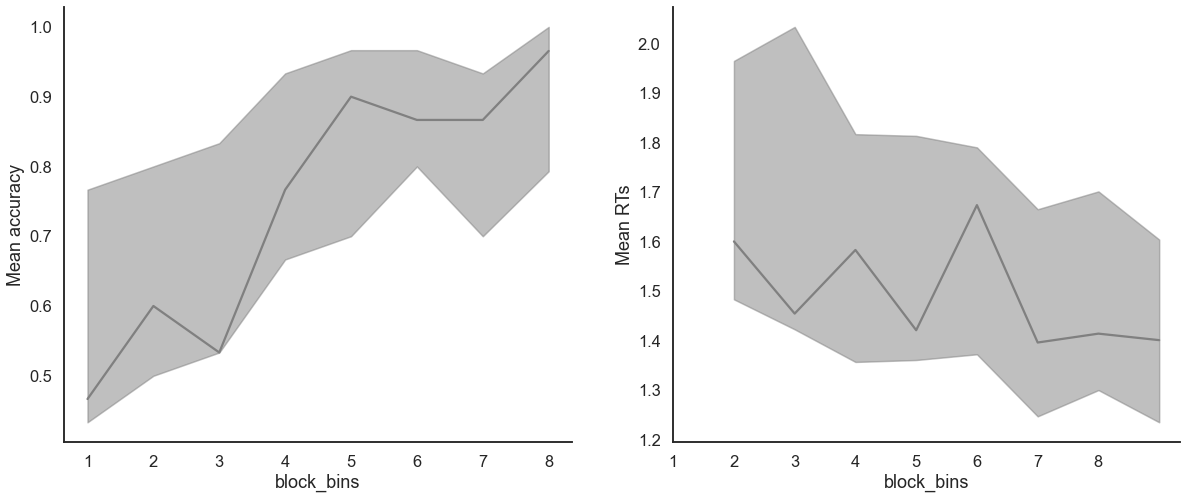

In [32]:
model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], 
                                                  n_posterior_predictives=100, 
                                                  figsize=(20,8));

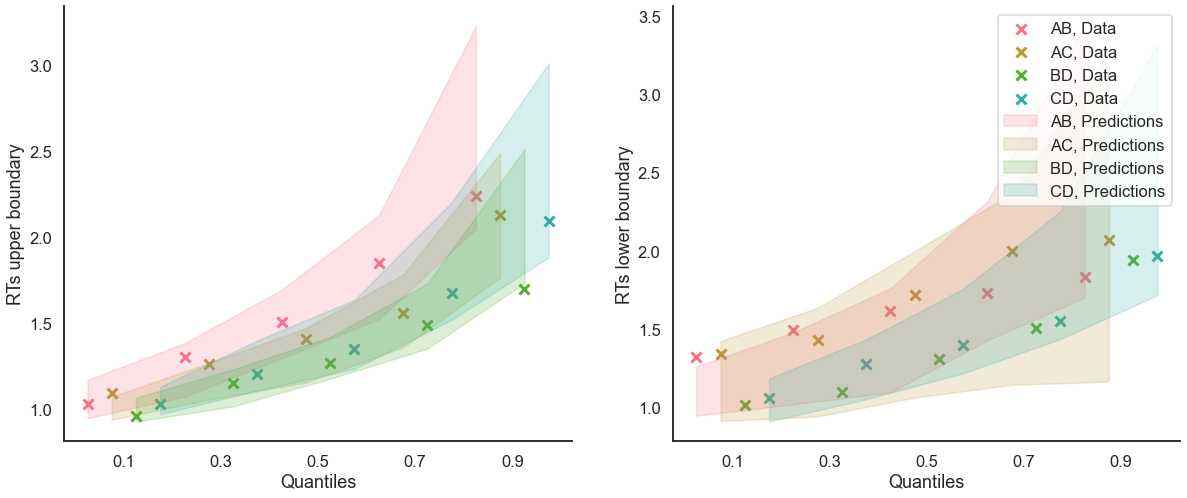

In [33]:
model_fit.plot_quantiles_grouped_posterior_predictives(n_posterior_predictives=100,
                                                        grouping_var='choice_pair',
                                                        kind='shades',
                                                        quantiles=[.1, .3, .5, .7, .9]);

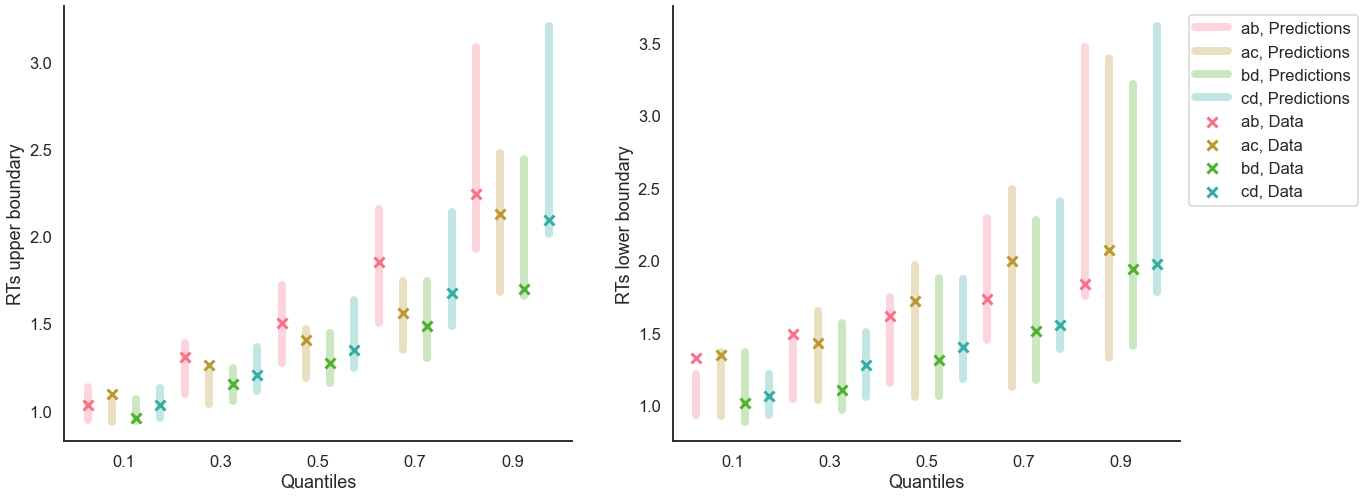

In [34]:
model_fit.plot_quantiles_grouped_posterior_predictives(
    n_posterior_predictives=300,
    grouping_var='choice_pair',
    palette = sns.color_palette('husl'),
    intervals_kws={'alpha': .3, 'lw':8},
    hue_order=['AB', 'AC', 'BD', 'CD'],
    hue_labels=['ab', 'ac', 'bd', 'cd']);